In [7]:
from time import time
import pandas as pd
import numpy as np
import SARpy
import operator
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import train_test_split
from pprint import pprint
from rdkit.Chem import AllChem as Chem
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.stats.multitest as smm

In [9]:
structures = pd.read_csv("../CAMDA_Model_Data/compounds_added_inactives.csv")
structures.rename(columns = {'standardized_smiles':'SMILES'}, inplace=True)
structures.head()

Unnamed: 0  PubChem_CID  Compound Name  \
0           0        34869     amineptine   
1           1         2717  chlormezanone   
2           2        65679       droxicam   
3           3        65869     ebrotidine   
4           4         4495     nimesulide   

                                            SMILES          MW  \
0               O=C(O)CCCCCCNC1c2ccccc2CCc2ccccc21  337.204179   
1                CN1C(=O)CCS(=O)(=O)C1c1ccc(Cl)cc1  273.022642   
2  CN1c2c(oc(=O)n(-c3ccccn3)c2=O)-c2ccccc2S1(=O)=O  357.041941   
3    NC(N)=Nc1nc(CSCCN=CNS(=O)(=O)c2ccc(Br)cc2)cs1  475.975849   
4       CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1Oc1ccccc1  308.046692   

         vDILIConcern  
0  vMost-DILI-Concern  
1  vMost-DILI-Concern  
2  vMost-DILI-Concern  
3  vMost-DILI-Concern  
4  vMost-DILI-Concern

In [10]:
structures
structures = structures[structures['vDILIConcern'] != 'vLess-DILI-Concern']
#structures['vDILIConcern'].replace(['vLess-DILI-Concern'], 'vMost-DILI-Concern', inplace = True)
#structures['vDILIConcern'].replace(['sider_inactive'], 'vNo-DILI-Concern', inplace = True)
structures = structures[structures['vDILIConcern'] != 'sider_inactive']
structures = structures[structures['vDILIConcern'] != 'Ambiguous DILI-concern']

In [12]:
structures.to_csv("../CAMDA_Model_Data/mcnc_for_Layla.csv")

In [13]:
structures
Compound_Name = structures['Compound Name'].tolist()
SMILES = structures.loc[:,['SMILES']]
#DILI = structures.loc[structures['vDILIConcern'] == 'vMost-DILI-Concern'].SMILES
#no_DILI = structures.loc[structures['vDILIConcern'] == 'vNo-DILI-Concern'].SMILES

In [14]:
def label (x):
    if x == 'vMost-DILI-Concern':
        return 1
    if x == 'vNo-DILI-Concern':
        return 0

In [15]:
SMILES['DILI_LABEL'] = structures['vDILIConcern'].apply(label)
SMILES.to_csv("Data_for_SARpy.csv")

In [16]:
data = pd.read_csv("Data_for_SARpy.csv")
x = data[['SMILES','DILI_LABEL']]
y = data['DILI_LABEL']
x.to_csv("Train_Data_for_SARpy.csv")

In [17]:
x.head()

SMILES  DILI_LABEL
0               O=C(O)CCCCCCNC1c2ccccc2CCc2ccccc21           1
1                CN1C(=O)CCS(=O)(=O)C1c1ccc(Cl)cc1           1
2  CN1c2c(oc(=O)n(-c3ccccn3)c2=O)-c2ccccc2S1(=O)=O           1
3    NC(N)=Nc1nc(CSCCN=CNS(=O)(=O)c2ccc(Br)cc2)cs1           1
4       CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1Oc1ccccc1           1

In [18]:
filt1 = SARpy.Filter('DILI_LABEL',0, operator.eq)
filt2 = SARpy.Filter('DILI_LABEL',1, operator.eq)
dictionary = {'INACTIVE':filt1, 'ACTIVE':filt2}
dataset = SARpy.loadDataset("Train_Data_for_SARpy.csv",'csv',dictionary,'SMILES')



Loading dataset...

 Read 401 molecular structures
('', 174, 'ACTIVE')
('', 227, 'INACTIVE')


In [19]:
SARpy.fragmentize(dataset,4,18)
rules = SARpy.extract(dataset, minHits = 5,minLR = 1, minPrecision = 0) # 'OPTIMAL'
SARpy.saveSmarts(rules,'ruleset.txt')



Fragmenting...	

 2095	substructures found...
 4480	substructures found...
 4806	substructures found...
 3325	substructures found...
 1654	substructures found...
 664	substructures found...
 185	substructures found...
 37	substructures found...
 5	substructures found...
 0	substructures found...

FRAGMENTS: 17251

Evaluating fragments on the training set...

    -> elapsed time: 37.64 seconds
         fragmentation 35.58 seconds
              matching 2.06 seconds


Extracting rules...	

 8798 ACTIVE substructures
  233 of which are potential alerts

 11401 INACTIVE substructures
  1639 of which are potential alerts

 Extracted:
 20	ACTIVE
 27	INACTIVE

RULES: 47

 -> time: 1.96 seconds


47 RULES have been saved


In [20]:
## Long winded way to get substructures for DILI (not for noDILI)

accuracy_list = []
sensitivity_list = []
specificity_list = []
SMARTS_list = []
LR_list = []
Target_list = []
test_comp_matched_list = []
for rule in rules:
    myrules = [rule,rule]
    SARpy.saveSmarts(myrules,'ruleset.txt')
    alerts = pd.read_csv("ruleset.txt", sep='\t')
    alerts = alerts.ix[1]
    #print(alerts)
    SMARTS = alerts['SMARTS']
    TARGET = alerts['Target']
    Target_list.append(TARGET)
#    if TARGET == 'ACTIVE':
        
    
    LR = alerts['Training LR']
    pred = SARpy.predict(myrules,dataset) #dataset_test
    if pred >= 1:
        accuracy,sensitivity,specificity = SARpy.validate(dataset) #
            #print(accuracy,sensitivity,specificity,LR, SMARTS)
        pred = (pred/167.0)*100
        test_comp_matched_list.append((pred))
        accuracy_list.append(accuracy)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        SMARTS_list.append(SMARTS)
        LR_list.append(LR)
            
            
        
    else:
        continue
        
        
df = pd.DataFrame()
df['SMARTS'] = SMARTS_list
df['TYPE'] = Target_list
df['Accuracy'] = accuracy_list
df['Sensitivity'] = sensitivity_list
df['Specificity'] = specificity_list
df['LR_training'] = LR_list
#df['Percent_matched_test_compounds'] = test_comp_matched_list
df



2 RULES have been saved


Predicting...

 23 structures matched


Validating...
lol

 Binary classification:
  INACTIVE = POSITIVE
  otherwise = NEGATIVE

 ACCURACY:	0.49
 sensitivity:	0.10
 specificity:	1.00

CONFUSION MATRIX:
YES	NO	<-any alert?
23	204	POSITIVES
0	174	NEGATIVES

 ACCURACY:	0.49
 sensitivity:	0.10
 specificity:	1.00

CONFUSION MATRIX:
YES	NO	<-any alert?
23	204	POSITIVES
0	174	NEGATIVES
  0.491271820449 = ss_accuracy


2 RULES have been saved


Predicting...

 18 structures matched


Validating...
lol

 Binary classification:
  INACTIVE = POSITIVE
  otherwise = NEGATIVE

 ACCURACY:	0.48
 sensitivity:	0.08
 specificity:	1.00

CONFUSION MATRIX:
YES	NO	<-any alert?
18	209	POSITIVES
0	174	NEGATIVES

 ACCURACY:	0.48
 sensitivity:	0.08
 specificity:	1.00

CONFUSION MATRIX:
YES	NO	<-any alert?
18	209	POSITIVES
0	174	NEGATIVES
  0.478802992519 = ss_accuracy


2 RULES have been saved


Predicting...

 10 structures matched


Validating...
lol

 Binary classification:
  ACTIV

/anaconda3/envs/myp2env/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  





Validating...
lol

 Binary classification:
  INACTIVE = POSITIVE
  otherwise = NEGATIVE

 ACCURACY:	0.45
 sensitivity:	0.03
 specificity:	1.00

CONFUSION MATRIX:
YES	NO	<-any alert?
7	220	POSITIVES
0	174	NEGATIVES

 ACCURACY:	0.45
 sensitivity:	0.03
 specificity:	1.00

CONFUSION MATRIX:
YES	NO	<-any alert?
7	220	POSITIVES
0	174	NEGATIVES
  0.451371571072 = ss_accuracy


2 RULES have been saved


Predicting...

 13 structures matched


Validating...
lol

 Binary classification:
  ACTIVE = POSITIVE
  otherwise = NEGATIVE

 ACCURACY:	0.59
 sensitivity:	0.06
 specificity:	0.99

CONFUSION MATRIX:
YES	NO	<-any alert?
11	163	POSITIVES
2	225	NEGATIVES

 ACCURACY:	0.59
 sensitivity:	0.06
 specificity:	0.99

CONFUSION MATRIX:
YES	NO	<-any alert?
11	163	POSITIVES
2	225	NEGATIVES
  0.588528678304 = ss_accuracy


2 RULES have been saved


Predicting...

 10 structures matched


Validating...
lol

 Binary classification:
  INACTIVE = POSITIVE
  otherwise = NEGATIVE

 ACCURACY:	0.46
 sensitivity:	



2 RULES have been saved


Predicting...

 34 structures matched


Validating...
lol

 Binary classification:
  INACTIVE = POSITIVE
  otherwise = NEGATIVE

 ACCURACY:	0.49
 sensitivity:	0.13
 specificity:	0.97

CONFUSION MATRIX:
YES	NO	<-any alert?
29	198	POSITIVES
5	169	NEGATIVES

 ACCURACY:	0.49
 sensitivity:	0.13
 specificity:	0.97

CONFUSION MATRIX:
YES	NO	<-any alert?
29	198	POSITIVES
5	169	NEGATIVES
  0.493765586035 = ss_accuracy


2 RULES have been saved


Predicting...

 41 structures matched


Validating...
lol

 Binary classification:
  ACTIVE = POSITIVE
  otherwise = NEGATIVE

 ACCURACY:	0.55
 sensitivity:	0.10
 specificity:	0.90

CONFUSION MATRIX:
YES	NO	<-any alert?
18	156	POSITIVES
23	204	NEGATIVES

 ACCURACY:	0.55
 sensitivity:	0.10
 specificity:	0.90

CONFUSION MATRIX:
YES	NO	<-any alert?
18	156	POSITIVES
23	204	NEGATIVES
  0.5536159601 = ss_accuracy


2 RULES have been saved


Predicting...

 36 structures matched


Validating...
lol

 Binary classification:
  INACTIV

SMARTS      TYPE  Accuracy  Sensitivity  Specificity  \
0    CC(c1ccccc1)CCN(C)C  INACTIVE  0.491272     0.101322     1.000000   
1           CC[N+](C)(C)  INACTIVE  0.478803     0.079295     1.000000   
2                c1ccco1    ACTIVE  0.591022     0.057471     1.000000   
3          O=CNCc1ccccc1    ACTIVE  0.586035     0.045977     1.000000   
4      N(CCN(C)CC(=O))CC  INACTIVE  0.458853     0.048458     0.994253   
5             CC1CCCCN1C  INACTIVE  0.488778     0.101322     0.994253   
6                NC(=O)N    ACTIVE  0.591022     0.063218     0.995595   
7        CNCCc1cccc(O)c1  INACTIVE  0.476309     0.074890     1.000000   
8           C1CCC(O)CC1O  INACTIVE  0.463840     0.052863     1.000000   
9      Nc1c(CC(=O))cccc1    ACTIVE  0.581047     0.034483     1.000000   
10         Nc4cccc(Cl)c4    ACTIVE  0.583541     0.040230     1.000000   
11             CN(C)CCOC  INACTIVE  0.488778     0.101322     0.994253   
12            CCN1CCCCC1  INACTIVE  0.496259     0.118943     0.988506   
13        CC(C)(C)CC(=O)  INACTIVE  0.451372     0.030837     1.000000   
14      C(=O)c1ccc(O)cc1    ACTIVE  0.588529     0.063218     0.991189   
15  CNCCc1c[nH]c2ccccc12  INACTIVE  0.458853     0.044053     1.000000   
16             P(=O)(O)O  INACTIVE  0.446384     0.026432     0.994253   
17          c3ccc(F)cc3F    ACTIVE  0.578554     0.028736     1.000000   
18          c1ccc(SC)cc1    ACTIVE  0.576060     0.028736     0.995595   
19                  CCCS  INACTIVE  0.451372     0.048458     0.977011   
20      CCNC(C)Cc1ccccc1  INACTIVE  0.483791     0.101322     0.982759   
21       OC(=O)C(CC(C)C)    ACTIVE  0.571072     0.028736     0.986784   
22    NS(=O)(=O)c2ccccc2    ACTIVE  0.583541     0.051724     0.991189   
23     CC(Cc1ccccc1)N(C)  INACTIVE  0.493766     0.123348     0.977011   
24           C2OC(C)CC2O  INACTIVE  0.456359     0.044053     0.994253   
25   c1ccc(Cc2ccccn2)cc1  INACTIVE  0.448878     0.030837     0.994253   
26        CC=C(c1ccccc1)    ACTIVE  0.573566     0.040230     0.982379   
27           CCN(C)C(=O)    ACTIVE  0.561097     0.057471     0.947137   
28             CCN(CC)CC  INACTIVE  0.541147     0.251101     0.919540   
29          Nc1c(C)cccc1    ACTIVE  0.588529     0.103448     0.960352   
30       CNC(=O)c1ccccc1  INACTIVE  0.451372     0.039648     0.988506   
31        C(=O)Cc2ccccc2    ACTIVE  0.563591     0.097701     0.920705   
32     CCC(c1ccccc1)C(C)  INACTIVE  0.498753     0.123348     0.988506   
33              COCC(C)C  INACTIVE  0.458853     0.079295     0.954023   
34   C(c1ccccc1)c1ccccc1  INACTIVE  0.466334     0.118943     0.919540   
35          c1ccc(Cl)cc1    ACTIVE  0.605985     0.183908     0.929515   
36              O=C(C)CC    ACTIVE  0.558603     0.080460     0.925110   
37        CCC(C)CCCC(C)C  INACTIVE  0.453865     0.088106     0.931034   
38        NCCc1ccc(O)cc1  INACTIVE  0.493766     0.127753     0.971264   
39            Oc1ccccc1C    ACTIVE  0.553616     0.103448     0.898678   
40             CC(O)CCCO  INACTIVE  0.488778     0.127753     0.959770   
41           c1[nH]cncc1    ACTIVE  0.571072     0.040230     0.977974   
42               CC(O)CO  INACTIVE  0.488778     0.176211     0.896552   
43                NCCCCC  INACTIVE  0.576060     0.330396     0.896552   
44               N(CC)CC  INACTIVE  0.635910     0.533040     0.770115   
45             Oc1ccccc1    ACTIVE  0.556110     0.321839     0.735683   
46              c1ccccc1    ACTIVE  0.528678     0.775862     0.339207   

    LR_training  
0           inf  
1           inf  
2           inf  
3           inf  
4          8.43  
5         17.63  
6         14.35  
7           inf  
8           inf  
9           inf  
10          inf  
11        17.63  
12        10.35  
13          inf  
14         7.18  
15          inf  
16         4.60  
17          inf  
18         6.52  
19         2.11  
20         5.88  
21         2.17  
22         5.87  
23         5.37  
24         7.67

In [21]:
df['Source'] = 'SARpy'

In [23]:
# Add Aleksandra MOSS substructures

MOSS_SS_Active = pd.read_csv("../CAMDA_Model_Data/Aleksandra_MOSS_Active.csv")
MOSS_SS_Inactive = pd.read_csv("../CAMDA_Model_Data/Aleksandra_MOSS_Inactive.csv")
MOSS_SS_Active = list(MOSS_SS_Active.columns.values)[3:]
MOSS_SS_Active = dict(zip(MOSS_SS_Active, ['ACTIVE'] * len(MOSS_SS_Active)))
MOSS_SS_Inactive = list(MOSS_SS_Inactive.columns.values)[3:]
MOSS_SS_Inactive = dict(zip(MOSS_SS_Inactive, ['INACTIVE'] * len(MOSS_SS_Inactive)))

MOSS_SS_Active = pd.DataFrame(MOSS_SS_Active.items(), columns=['SMARTS', 'TYPE'])
MOSS_SS_Inactive = pd.DataFrame(MOSS_SS_Inactive.items(), columns=['SMARTS', 'TYPE'])

In [24]:
MOSS_SS = pd.concat([MOSS_SS_Active,MOSS_SS_Inactive])
MOSS_SS['Source'] = 'MOSS'
df = pd.concat([MOSS_SS,df])

/anaconda3/envs/myp2env/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# Add literature SMARTS

Literature_SMARTS = pd.read_csv("../CAMDA_Model_Data/Literature_SMARTS.csv")

In [26]:
Literature_SMARTS['Source'] = 'Hewitt et al. (2013)'
Literature_SMARTS['Source'][16:] = "Liu et al. (2015)"
Literature_SMARTS

SMARTS    TYPE  \
0   C(=C(c1ccccc1)c2ccc(cc2)OCCN(C)C)c3ccccc3  ACTIVE   
1                      c1nc2c(n1)c(ncn2)[NH2]  ACTIVE   
2                                O=CC=CC=CC=C  ACTIVE   
3                                  C1C(=O)NC1  ACTIVE   
4                        C1C(=O)NC(=O)NC1(=O)  ACTIVE   
5            c1ccc2c(c1)N(CCCN(C)C)c3ccccc3S2  ACTIVE   
6                             c1(N)nc(=O)ncc1  ACTIVE   
7                        c1([OH])c([OH])cccc1  ACTIVE   
8                         O=CC[NH]CC(=O)N(C)C  ACTIVE   
9              C12CCC3C(C1CCC2)CCc4c3ccc(c4)O  ACTIVE   
10                                  [C,c][SH]  ACTIVE   
11                           ClCCN([C,P])CCCl  ACTIVE   
12           C1CCC2C1(CCC3C2CCC4=CC(=O)CCC34)  ACTIVE   
13          C12CCC3C(C1CCC2)CCC4=CC(=O)C=CC34  ACTIVE   
14                                       CSSC  ACTIVE   
15                  [NH2]c1ccc(S(=O)(=O)N)cc1  ACTIVE   
16                      C12CCCCC1C3C(CCC3)CC2  ACTIVE   
17                                         NN  ACTIVE   
18                            a[C!R]C(=O)[OH]  ACTIVE   
19                         [#6]S(=O)(=O)N[#6]  ACTIVE   
20                              c1ccccc1[NH2]  ACTIVE   
21                                 O = [S;X3]  ACTIVE   
22                                  [S;X2&!R]  ACTIVE   
23                                a[C!R](=O)a  ACTIVE   
24                               C[F,Cl,Br,I]  ACTIVE   
25                                     C1CC1N  ACTIVE   
26                           [O]c1ccc([N])cc1  ACTIVE   
27                       N1c2ccccc2Sc2ccccc12  ACTIVE   

                                                Paper                Source  
0        https://www.ncbi.nlm.nih.gov/pubmed/23875763  Hewitt et al. (2013)  
1        https://www.ncbi.nlm.nih.gov/pubmed/23875764  Hewitt et al. (2013)  
2        https://www.ncbi.nlm.nih.gov/pubmed/23875765  Hewitt et al. (2013)  
3        https://www.ncbi.nlm.nih.gov/pubmed/23875766  Hewitt et al. (2013)  
4        https://www.ncbi.nlm.nih.gov/pubmed/23875767  Hewitt et al. (2013)  
5        https://www.ncbi.nlm.nih.gov/pubmed/23875768  Hewitt et al. (2013)  
6        https://www.ncbi.nlm.nih.gov/pubmed/23875769  Hewitt et al. (2013)  
7        https://www.ncbi.nlm.nih.gov/pubmed/23875770  Hewitt et al. (2013)  
8        https://www.ncbi.nlm.nih.gov/pubmed/23875771  Hewitt et al. (2013)  
9        https://www.ncbi.nlm.nih.gov/pubmed/23875772  Hewitt et al. (2013)  
10       https://www.ncbi.nlm.nih.gov/pubmed/23875773  Hewitt et al. (2013)  
11       https://www.ncbi.nlm.nih.gov/pubmed/23875774  Hewitt et al. (2013)  
12       https://www.ncbi.nlm.nih.gov/pubmed/23875775  Hewitt et al. (2013)  
13       https://www.ncbi.nlm.nih.gov/pubmed/23875776  Hewitt et al. (2013)  
14       https://www.ncbi.nlm.nih.gov/pubmed/23875777  Hewitt et al. (2013)  
15       https://www.ncbi.nlm.nih.gov/pubmed/23875778  Hewitt et al. (2013)  
16  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
17  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
18  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
19  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
20  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
21  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
22  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
23  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
24  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
25  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
26  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)  
27  https://jcheminf.biomedcentral.com/articles/10...     Liu et al. (2015)

In [27]:
df = pd.concat([Literature_SMARTS,df])

/anaconda3/envs/myp2env/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [29]:
# Drugbank approved

Drugbank = pd.read_csv("./DrugBank_5_1_4_approved.csv")
Drugbank = Drugbank[pd.notnull(Drugbank['SMILES'])]
Drugbank.drop_duplicates(subset='SMILES', keep="first",inplace=True)
Drugbank_comps = Drugbank['SMILES'].tolist()

In [32]:
## Tabulate results


#https://www.rdkit.org/docs/GettingStartedInPython.html#substructure-searching

df2 = pd.DataFrame(index = x['SMILES'])
df2['DILI_LABEL'] = x['DILI_LABEL'].to_list()
df2['Compound_Name'] = Compound_Name

substructure_stats = pd.DataFrame()

#generate FPs
smis = list(df2.index)

mols = [Chem.MolFromSmiles(smile) for smile in smis]

fps_bit = [list(Chem.GetMorganFingerprintAsBitVect(mol,2, nBits=2048)) for mol in mols]


h = 0 # count TPs
l = 0 # count FPs
smart_list = []
PPV_list = []
percent_hits = []
labels = []
sources = []
odds_ratio_list = []
p_value_list = []
perc_hit_list = []
type_list = []
DB_count_list = []
for index, row in df.iterrows():
    i=0
    j=0
    k=0
    z=0
    t=0
    c=0
    v=0
    DB_count = 0
    hit_list = []
    smart = row['SMARTS']
    TYPE = row['TYPE']
    source = row['Source']
    
 
    if TYPE == 'ACTIVE':
        for DB in Drugbank_comps:
            m = Chem.MolFromSmiles(DB)
            patt = Chem.MolFromSmarts(smart)
            if m.HasSubstructMatch(patt):
                DB_count+=1
            else:
                continue
        DB_count_list.append(DB_count)
    
    
        for index, row in x.iterrows():
            label = row['DILI_LABEL']
            a = row['SMILES']   
            m = Chem.MolFromSmiles(a)
            patt = Chem.MolFromSmarts(smart)
            if m.HasSubstructMatch(patt) is True:
                i+=1
            if m.HasSubstructMatch(patt) is True and label == 1: # True positive
                #print('TP')
                j+=1
            if m.HasSubstructMatch(patt) is True and label == 0: # False positive
                #print('FP')
                k+=1
            if m.HasSubstructMatch(patt) is True:
                hit_list.append(1)
            if m.HasSubstructMatch(patt) is False:
                hit_list.append('0')
                
                
            if m.HasSubstructMatch(patt) is True and label == 1: # compound is DILI and has SS
                z+=1
            if m.HasSubstructMatch(patt) is False and label == 1: # compound is DILI and does not have SS
                t+=1
            if m.HasSubstructMatch(patt) is True and label == 0: # compound is noDILI and has SS
                c+=1
            if m.HasSubstructMatch(patt) is False and label == 0: # compound is noDILI and does not have SS
                v+=1    
                
            
        #print(j)
        #print(len(x.loc[x['DILI_LABEL']==1]))
        perc_hits = (j*1.0/len(x.loc[x['DILI_LABEL']==1]))*100.0
        percent_hits.append(perc_hits)
        labels.append(0)

        if source == 'Hewitt et al. (2013)':
            sources.append(0)
        elif source == 'Liu et al. (2015)':
            sources.append(1)
        elif source == 'SARpy':
            sources.append(2)
        else:
            sources.append(3)
        
    elif TYPE == 'INACTIVE':
        continue
        for index, row in x.iterrows(): # Test set
            label = row['DILI_LABEL']
            a = row['SMILES']   
            m = Chem.MolFromSmiles(a)
            patt = Chem.MolFromSmarts(smart)
            if m.HasSubstructMatch(patt) is True:
                i+=1
            if m.HasSubstructMatch(patt) is True and label == 0: # True positive
                #print('TP')
                j+=1
            if m.HasSubstructMatch(patt) is True and label == 1: # False positive
                #print('FP')
                k+=1
            if m.HasSubstructMatch(patt) is True:
                hit_list.append(1)
            if m.HasSubstructMatch(patt) is False:
                hit_list.append('0')
                
            if m.HasSubstructMatch(patt) is True and label == 0: # compound is noDILI and has SS
                z+=1
            if m.HasSubstructMatch(patt) is False and label == 0: # compound is noDILI and does not have SS
                t+=1
            if m.HasSubstructMatch(patt) is True and label == 1: # compound is DILI and has SS
                c+=1
            if m.HasSubstructMatch(patt) is False and label == 1: # compound is DILI and does not have SS
                v+=1
                
                
                
        #print(j)
        #print(len(x.loc[x['DILI_LABEL']==0]))
        perc_hits = (j*1.0/len(x.loc[x['DILI_LABEL']==0]))*100.0
        percent_hits.append(perc_hits)
        labels.append(1)
        if source == 'Hewitt et al. (2013)':
            sources.append(0)
        elif source == 'Liu et al. (2015)':
            sources.append(1)
        elif source == 'SARpy':
            sources.append(2)
        else:
            sources.append(3)
    
    if ((j+k) == 0):
        PPV = 0
    else:
    
        PPV = (j/(j+k*1.0))
        print('{0:.3f}'.format(PPV), smart, perc_hits) # positive predictive value (most important for substructures to classify DILI)

    PPV_list.append(PPV)
    
    # Fisher one-sided test
    
    oddsratio, pvalue = stats.fisher_exact([[z, c], [t, v]], alternative='greater')
    
    odds_ratio_list.append(oddsratio)
    p_value_list.append(pvalue)
    perc_hit_list.append(perc_hits)
    type_list.append(TYPE)
    smart_list.append(smart)


    if PPV >= 0.0: # filter for PPV
    
        #df2[smart+'_'+TYPE] = hit_list
        print(TYPE,i,j,k,pvalue,oddsratio,source,len(x['SMILES']),len(x.loc[x['DILI_LABEL']==1]),len(x.loc[x['DILI_LABEL']==0]))
        df2[smart] = hit_list
 
        h+=j
        l+=k
        #PPV_list[smart] = PPV
    else:
        continue
        
substructure_stats = pd.DataFrame(index = smart_list)
substructure_stats['PPV'] = PPV_list
substructure_stats['Source'] = sources
substructure_stats['odds_ratio'] = odds_ratio_list
substructure_stats['p_value'] = p_value_list
substructure_stats['perc_hits'] = perc_hit_list
substructure_stats['type'] = type_list


print(h,l) # number of TPs and FPs

RDKit ERROR: [10:26:20] Explicit valence for atom # 2 O, 3, is greater than permitted


AttributeError: 'NoneType' object has no attribute 'HasSubstructMatch'

In [20]:
len(type_list)
#substructure_stats.shape

268

In [21]:
# http://jpktd.blogspot.com/2013/04/multiple-testing-p-value-corrections-in.html
rej, pval_corr = smm.multipletests(p_value_list, method='fdr_bh')[:2]
substructure_stats['BH_Adjusted_p_value'] = list(pval_corr)

In [22]:
substructure_stats
#substructure_stats.loc[substructure_stats['perc_hits'] > 30]
#substructure_stats.loc[['s=o']]

PPV  Source  \
C(=C(c1ccccc1)c2ccc(cc2)OCCN(C)C)c3ccccc3           1.000000       0   
c1nc2c(n1)c(ncn2)[NH2]                              0.000000       0   
O=CC=CC=CC=C                                        1.000000       0   
C1C(=O)NC1                                          0.000000       0   
C1C(=O)NC(=O)NC1(=O)                                0.000000       0   
c1ccc2c(c1)N(CCCN(C)C)c3ccccc3S2                    1.000000       0   
c1(N)nc(=O)ncc1                                     1.000000       0   
c1([OH])c([OH])cccc1                                0.300000       0   
O=CC[NH]CC(=O)N(C)C                                 1.000000       0   
C12CCC3C(C1CCC2)CCc4c3ccc(c4)O                      1.000000       0   
[C,c][SH]                                           0.000000       0   
ClCCN([C,P])CCCl                                    1.000000       0   
C1CCC2C1(CCC3C2CCC4=CC(=O)CCC34)                    0.285714       0   
C12CCC3C(C1CCC2)CCC4=CC(=O)C=CC34                   0.500000       0   
CSSC                                                0.250000       0   
[NH2]c1ccc(S(=O)(=O)N)cc1                           1.000000       0   
C12CCCCC1C3C(CCC3)CC2                               0.352941       1   
NN                                                  1.000000       1   
a[C!R]C(=O)[OH]                                     0.916667       1   
[#6]S(=O)(=O)N[#6]                                  0.705882       1   
c1ccccc1[NH2]                                       0.857143       1   
O = [S;X3]                                          0.430556       1   
[S;X2&!R]                                           0.500000       1   
a[C!R](=O)a                                         0.916667       1   
C[F,Cl,Br,I]                                        0.565217       1   
C1CC1N                                              0.800000       1   
[O]c1ccc([N])cc1                                    0.666667       1   
N1c2ccccc2Sc2ccccc12                                1.000000       1   
O-C(-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-C             0.000000       3   
N(-C-C(-N)=O)-C-C-N-C-C                             0.100000       3   
...                                                      ...     ...   
N-C1-C(-C(-C(-C(-C-1)-N)-O)-O)-O-C1-O-C(-C(-C(-...  0.000000       3   
N-C(-C-C-C-C)=O                                     0.315789       3   
N-C-C-C(-O)(-c1:c:c:c:c:c:1)-C                      0.000000       3   
N-C1-C(-C(-C(-C(-C-1)-N)-O)-O)-O-C                  0.000000       3   
O-C1-C(-C-C-C-C-1)-C                                0.076923       3   
N(-C-C(-C-C)-C)-C                                   0.257143       3   
O-C(-C-C-C=O)=O                                     0.000000       3   
N(-C-C)=C(-N)-N                                     0.166667       3   
N-C-C(-O)-C-O-c1:c:c:c:c:c:1                        0.000000       3   
N-C1-C(-C(-C(-C(-C-1)-N)-O)-O)-O-C1-O-C(-C(-C-C...  0.000000       3   
c1ccco1                                             1.000000       2   
O=CNCc1ccccc1                                       1.000000       2   
NC(=O)N                                             0.916667       2   
Nc1c(CC(=O))cccc1                                   1.000000       2   
Nc4cccc(Cl)c4                                       1.000000       2   
C(=O)c1ccc(O)cc1                                    0.846154       2   
c3ccc(F)cc3F                                        1.000000       2   
c1ccc(SC)cc1                                        0.833333       2   
OC(=O)C(CC(C)C)                                     0.625000       2   
NS(=O)(=O)c2ccccc2                                  0.818182       2   
CC=C(c1ccccc1)                                      0.636364       2   
CCN(C)C(=O)                                         0.454545       2   
Nc1c(C)cccc1                                        0.666667       2   
C(=O)Cc2ccccc2                                      0.485714       2   
c1ccc(Cl)cc1             

In [23]:
# ECFP+SS feature importance table

Feature_imps = pd.read_csv("./CAMDA_Model_Data/feature_importances_ECFP_substruct_RF.csv")
Feature_imps.sort_values(by=['importances'],ascending=False)[:20].head()

# top 20 - 7/50 SS, 13/2048 ecfp

Unnamed: 0 features  importances
35            35   NCCCCC     0.016159
1909        1909     1873     0.011034
116          116       80     0.007629
1416        1416     1380     0.007617
263          263      227     0.007452

In [24]:
df2.head()
import collections
print [item for item, count in collections.Counter(percent_hits).items() if count > 1]


[0.0, 7.471264367816093, 5.747126436781609, 5.172413793103448, 4.022988505747127, 1.1494252873563218, 1.7241379310344827, 2.2988505747126435, 4.597701149425287, 0.5747126436781609, 2.8735632183908044, 6.321839080459771, 3.4482758620689653, 10.344827586206897]


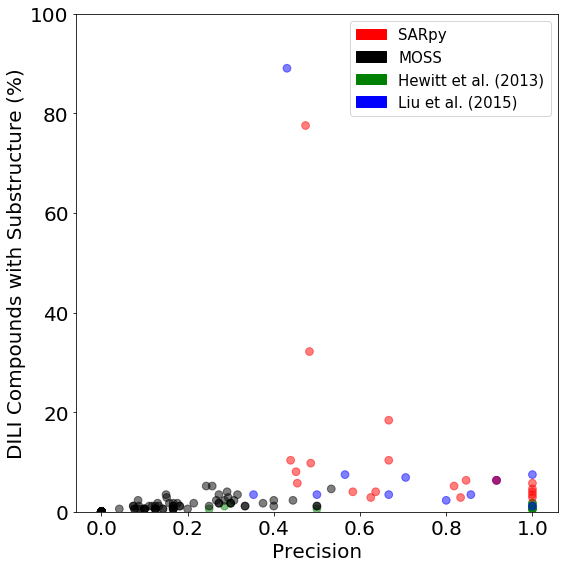

In [32]:
colors = ['green','blue','red','black']
fig = plt.figure(figsize=(8,8))
plt.scatter(PPV_list,percent_hits, c=sources, cmap=matplotlib.colors.ListedColormap(colors),alpha=0.5, s=60)
plt.xlabel("Precision")
plt.ylabel("DILI Compounds with Substructure (%)")
plt.ylim([0,100])
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=15)
pop_a = mpatches.Patch(color='red', label='SARpy')
pop_b = mpatches.Patch(color='black', label='MOSS')
pop_c = mpatches.Patch(color='green', label='Hewitt et al. (2013)')
pop_d = mpatches.Patch(color='blue', label='Liu et al. (2015)')
plt.legend(handles=[pop_a,pop_b,pop_c, pop_d])
plt.tight_layout()
plt.savefig("substructure_hit_vs_ppv_source_comparison_DILI_Only.svg")
plt.show()

In [56]:
df2.loc[df2['c1ccc(Cl)cc1']==1]

DILI_LABEL  \
SMILES                                                           
CN1C(=O)CCS(=O)(=O)C1c1ccc(Cl)cc1                            1   
CC(N)C(=O)OC(C)(C)Cc1ccc(Cl)cc1                              1   
C=CCOc1ccc(CC(=O)O)cc1Cl                                     1   
CCCN(CCC)C(=O)Cc1c(-c2ccc(Cl)cc2)nc2ccc(Cl)cn12              1   
CC(C(=O)O)c1ccc2oc(-c3ccc(Cl)cc3)nc2c1                       1   
CN(C)CCCC1c2ccccc2Nc2ccc(Cl)cc21                             1   
COc1ccc2c(C(=O)c3ccc(Cl)cc3)c(C)n(CC(=O)O)c2c1               1   
O=C(O)Cc1csc(-c2ccc(Cl)cc2)n1                                1   
O=C(COc1ccc(Cl)cc1)N1CCN(Cc2ccc3c(c2)OCO3)CC1                1   
O=C(OCC(O)CO)c1ccccc1Nc1ccnc2cc(Cl)ccc12                     1   
Cc1ccc(Nc2c(F)cccc2Cl)c(CC(=O)O)c1                           1   
NC(=O)C1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1                  1   
CC(C(=O)O)c1ccc(N2CC=CC2)c(Cl)c1                             1   
O=C(O)COc1ccc(C(=O)c2cccs2)c(Cl)c1Cl                         1   
CN1CCC(Nc2ncc3ncnc(Nc4ccc(F)c(Cl)c4)c3n2)CC1                 1   
CC(=O)N1CCN(c2ccc(OC[C@@H]3CO[C@@](Cn4ccnc4)(c4...           1   
CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc...           1   
CCc1nn(CCCN2CCN(c3cccc(Cl)c3)CC2)c(=O)n1CCOc1cc...           1   
O=c1[nH]c2cc(Cl)ccc2o1                                       1   
CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21                            1   
CN1CCN(C2=c3ccccc3=Nc3ccc(Cl)cc3N2)CC1                       1   
O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl                               1   
O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1                 1   
COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1               1   
COC1=CC(=O)C[C@@H](C)[C@]12Oc1c(Cl)c(OC)cc(OC)c...           1   
COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1               1   
CCC(C)n1ncn(-c2ccc(N3CCN(c4ccc(OC[C@H]5CO[C@](C...           1   
Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1                                1   
CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c...           1   
Clc1ccccc1CN1CCc2sccc2C1                                     1   
Clc1ccc2nsnc2c1NC1=NCCN1                                     1   
Cc1ccccc1C(=O)Nc1ccc(C(=O)N2CCCC(O)c3cc(Cl)ccc3...           1   
CC[N+](CC)(CCNC(=O)C(=O)NCC[N+](CC)(CC)Cc1ccccc...           0   
CN(C)CCOC(c1ccc(Cl)cc1)c1ccccn1                              0   
CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1                               0   
CN1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1                0   
CCCC(=O)OCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc...           0   
NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1                       0   
Clc1ccc2c(c1)C(c1ccccc1)=NCc1nncn1-2                         0   
Oc1ccc(C2CNCCc3c2cc(O)c(O)c3Cl)cc1                           0   
OCCOCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1                      0   
CN(C)C(=O)C(CCN1CCC(O)(c2ccc(Cl)cc2)CC1)(c1cccc...           0   
CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1                 0   
Cc1cccc(CN2CCN(C(c3ccccc3)c3ccc(Cl)cc3)CC2)c1                0   
Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2                       0   
Clc1ccc(C(c2ccccc2Cl)C(Cl)Cl)cc1                             0   
Fc1ccccc1C1=NCC(=S)N(CC(F)(F)F)c2ccc(Cl)cc21                 0   
O=P(O)(O)C(Sc1ccc(Cl)cc1)P(=O)(O)O                           0   

                                                       Compound_Name  \
SMILES                                                                 
CN1C(=O)CCS(=O)(=O)C1c1ccc(Cl)cc1                      chlormezanone   
CC(N)C(=O)OC(C)(C)Cc1ccc(Cl)cc1                          alaproclate   
C=CCOc1ccc(CC(=O)O)cc1Cl                                  alclofenac   
CCCN(CCC)C(=O)Cc1c(-c2ccc(Cl)cc2)nc2ccc(Cl)cn12              alpidem   
CC(C(=O)O)c1ccc2oc(-c3ccc(Cl)cc3)nc2c1                  benoxaprofen   
CN(C)CCCC1c2ccccc2Nc2ccc(Cl)cc21                           clomacran   
COc1ccc2c(C(=O)c3ccc(Cl)cc3)c(C)n(CC(=O)O)c2c1            clometacin   
O=C(O)Cc1csc(-c2ccc(Cl)cc2)n1                         fenclozic acid   
O=C(COc1ccc(Cl)cc1)N1CCN(Cc2ccc

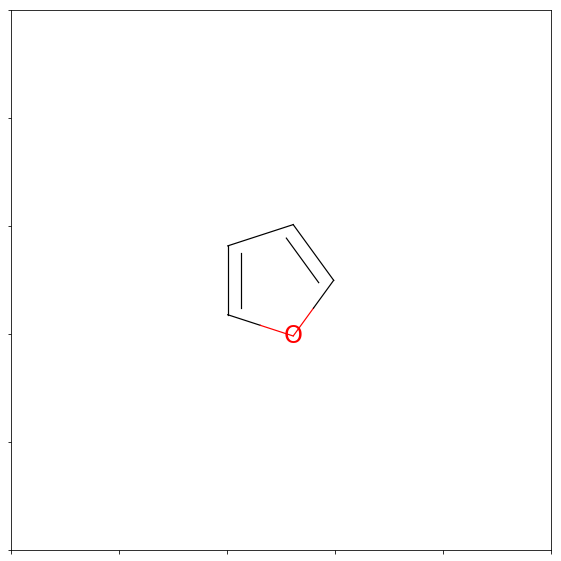

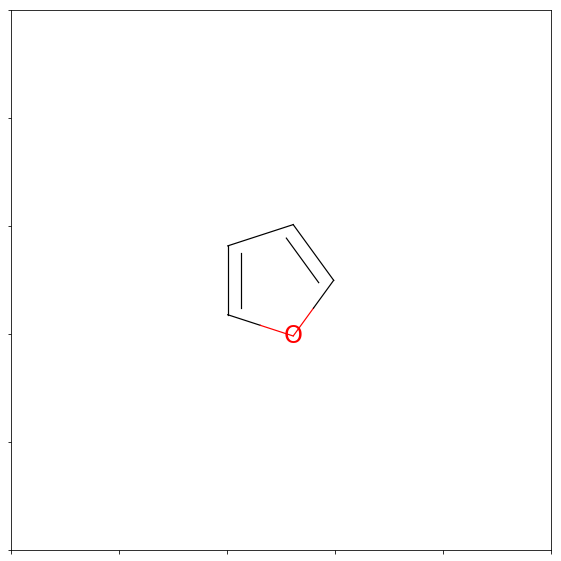

In [50]:
# Drawing

p = Chem.MolFromSmarts('c1ccco1')
AllChem.Compute2DCoords(p)
#p
Draw.MolToMPL(p)

In [82]:
#df2#.values[1:50]
#df3 = df2.loc[:, df2.columns != 'DILI_LABEL']
#df3 = df2.loc[np.sum(df2.iloc[:,:-1]>0, axis=1)[lambda x: x>=8].index]
#df3
#df3 = df2
#df3.drop(df3.columns[0], axis=1, inplace=True)
#df3[(df3.T != 1).all()]
#df2.loc[df2['DILI_LABEL'] == 0][:1]

In [23]:
lol = pd.DataFrame(fps_bit)
kept_substructures = df2.columns.values.tolist()[3:]
df3 = df2.copy()
df3.reset_index(inplace=True)
df3 = pd.concat([df3, lol], axis=1, sort=False)

In [22]:
df3.to_csv("Substructure_Matrix_min4_max18_minhit5_minLR1_minPres0_PPV0_MOSS_Literature_ADDED_Aleksandra.csv")

In [25]:
# External ambiguous SMILES

external_test = pd.read_csv("./CAMDA_Model_Data/external_ambiguous_smiles.csv")
external_test.head()

Compound Name                                standardized_smiles
0    amantadine                              NC12CC3CC(CC(C3)C1)C2
1    anagrelide                     O=C1CN2Cc3c(ccc(Cl)c3Cl)NC2=N1
2    bumetanide         CCCCNc1cc(C(=O)O)cc(S(N)(=O)=O)c1Oc1ccccc1
3     diazoxide                       CC1=NS(=O)(=O)c2cc(Cl)ccc2N1
4  dipyridamole  OCCN(CCO)c1nc(N2CCCCC2)c2nc(N(CCO)CCO)nc(N3CCC...

In [26]:
# New compound get substructure vector

test_smile = "C[C@H](N)C(=O)N[C@@H](C)C(=O)NC1[C@@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)C[C@H]12"

def get_substructure_vect(smile):
    vect = []
    for smart in kept_substructures: # HARD CODED.....
        a = smile   
        m = Chem.MolFromSmiles(a)
        fps = list(Chem.GetMorganFingerprintAsBitVect(m,2, nBits=2048))
        #print(smart)
        patt = Chem.MolFromSmarts(smart)
        if m.HasSubstructMatch(patt) is True:
            vect.append(1)
        else:
            vect.append(0)
    return(vect+fps)


In [27]:
listz = []
for index, row in external_test.iterrows():
    listz.append(get_substructure_vect(row['standardized_smiles']))

In [28]:
external_df = pd.DataFrame(listz,columns=df3.columns.values.tolist()[4:])
external_df = pd.concat([external_test, external_df], axis=1, sort=False)
external_df.head()

Compound Name                                standardized_smiles  \
0    amantadine                              NC12CC3CC(CC(C3)C1)C2   
1    anagrelide                     O=C1CN2Cc3c(ccc(Cl)c3Cl)NC2=N1   
2    bumetanide         CCCCNc1cc(C(=O)O)cc(S(N)(=O)=O)c1Oc1ccccc1   
3     diazoxide                       CC1=NS(=O)(=O)c2cc(Cl)ccc2N1   
4  dipyridamole  OCCN(CCO)c1nc(N2CCCCC2)c2nc(N(CCO)CCO)nc(N3CCC...   

   O=CC=CC=CC=C  c1ccc2c(c1)N(CCCN(C)C)c3ccccc3S2  c1(N)nc(=O)ncc1  \
0             0                                 0                0   
1             0                                 0                0   
2             0                                 0                0   
3             0                                 0                0   
4             0                                 0                0   

   O=CC[NH]CC(=O)N(C)C  C12CCC3C(C1CCC2)CCc4c3ccc(c4)O  ClCCN([C,P])CCCl  \
0                    0                               0                 0   
1                    0                               0                 0   
2                    0                               0                 0   
3                    0                               0                 0   
4                    0                               0                 0   

   [NH2]c1ccc(S(=O)(=O)N)cc1  NN  ...  2038  2039  2040  2041  2042  2043  \
0                          0   0  ...     0     0     0     0     0     0   
1                          0   0  ...     0     0     0     0     0     0   
2                          0   0  ...     0     0     0     0     0     0   
3                          0   0  ...     0     0     0     0     0     0   
4                          0   0  ...     0     0     0     0     0     0   

   2044  2045  2046  2047  
0     0     0     0     0  
1     0     0     0     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     0     0  

[5 rows x 2099 columns]

In [29]:
external_df.to_csv("Ambiguos_Substructure_Matrix_min4_max18_minhit5_minLR1_minPres0_PPV0_8_MOSS_Literature_ADDED.csv")